In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import gpplot as gpp 
gpp.set_aesthetics(context = 'paper')

In [2]:
file_path = "../../Data/primaryLibrary/"
figure1_outpath = '../../Figures/Figure 1/'

In [3]:
#read in combined screening data
merged_df = pd.read_csv(file_path + "inHouseDatasetsCombined.csv")

#separate controls into separate categories
merged_df['detailedCategory'] = np.where(merged_df['Target Gene Symbol'].str.contains('NO_SITE'), 'No Site Control',
                   np.where(merged_df['Target Gene Symbol'].str.contains('ONE_INTERGENIC'), 'One Intergenic Control', 
                            merged_df['Category']))
merged_df['detailedCategory'].value_counts()

Essential                 59553
Non-essential             45316
One Intergenic Control      993
No Site Control             990
Name: detailedCategory, dtype: int64

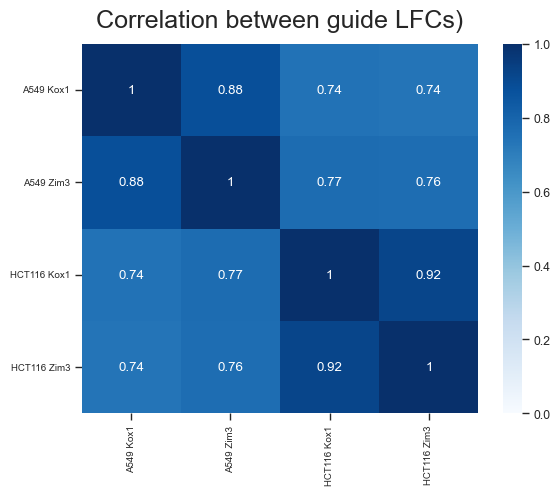

In [4]:
#heatmap of correlations between guide LFCs
labels = ['A549 Kox1', 'A549 Zim3', 'HCT116 Kox1', 'HCT116 Zim3']
guide_heatmap = sns.heatmap(merged_df[['avg_lfc_A549_Kox1', 'avg_lfc_A549_Zim3', 'avg_lfc_HCT116_Kox1', 'avg_lfc_HCT116_Zim3',]].corr(), 
            annot=True, vmin=0, vmax=1, cmap='Blues',xticklabels=labels,yticklabels=labels)
guide_heatmap.set_title('Correlation between guide LFCs)', fontdict={'fontsize':18}, pad=12)
plt.xticks(rotation=90,fontsize=7)
plt.yticks(rotation=0,fontsize=7)
gpp.savefig(figure1_outpath+'Guide_Level_LFC_Heatmap.pdf', dpi=300, bbox_inches='tight')

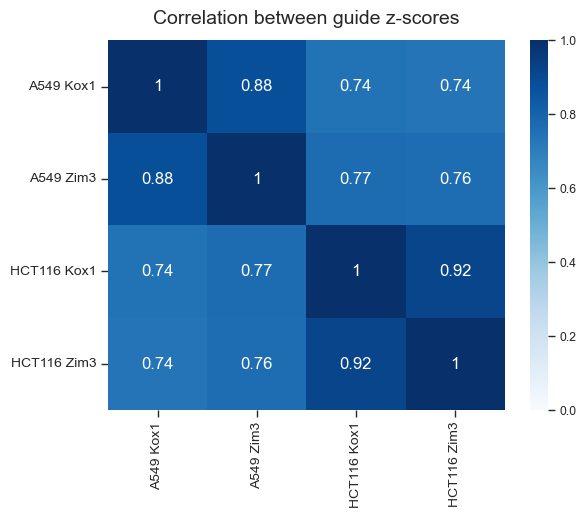

In [5]:
#heatmap of correlations between guide z-scores
guide_heatmap = sns.heatmap(merged_df[['z_scored_avg_lfc_A549_Kox1', 'z_scored_avg_lfc_A549_Zim3', 
                                       'z_scored_avg_lfc_HCT116_Kox1', 'z_scored_avg_lfc_HCT116_Zim3']]\
                                     .rename(columns={'z_scored_avg_lfc_A549_Zim3': "A549 Zim3", 
                                                      "z_scored_avg_lfc_A549_Kox1": "A549 Kox1", 
                                                      "z_scored_avg_lfc_HCT116_Zim3": "HCT116 Zim3",
                                                     "z_scored_avg_lfc_HCT116_Kox1": "HCT116 Kox1"}).corr(), 
            annot=True, 
            annot_kws={"size": 12}, vmin=0, vmax=1, cmap='Blues')
guide_heatmap.set_title('Correlation between guide z-scores', fontdict={'fontsize':14}, pad=12)
plt.xticks(rotation=90,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
gpp.savefig(figure1_outpath+'Guide_Level_Zscore_Heatmap.pdf', dpi=300, bbox_inches='tight')

In [6]:
#create dataframe that can be used to create boxplots of guide LFCs stratified by gene essentiality
lfc_columns = merged_df.columns[merged_df.columns.str.startswith('avg_lfc')].tolist()
plot_df = merged_df[['Category'] + lfc_columns].melt(id_vars = 'Category', var_name = 'condition', value_name = 'Average LFC')
plot_df['condition'] = plot_df['condition'].str.split('_',expand=True)[2] + ' ' + plot_df['condition'].str.split('_',expand=True)[3]

plot_df = plot_df[~plot_df['Category'].str.contains('INTERGENIC')]
plot_df.head()

,Category,condition,Average LFC
0,Non-essential,A549 Zim3,0.216872
1,Essential,A549 Zim3,-0.268908
2,Essential,A549 Zim3,-0.024939
3,Essential,A549 Zim3,-0.105666
4,Non-essential,A549 Zim3,-0.292964


In [7]:
#calculate ssmd between nonessential and essential targeting guide LFCs
ssmd_df = plot_df.groupby(['condition','Category']).agg(mean = ('Average LFC','mean'),
                                              std = ('Average LFC','std')).reset_index()
ssmd_df = ssmd_df.pivot(columns = 'Category', index = 'condition', values = ['mean','std']).reset_index()
ssmd_df['mean_diff'] = ssmd_df['mean']['Non-essential'] - ssmd_df['mean']['Essential']
ssmd_df['pooled_std'] = np.sqrt(ssmd_df['std']['Non-essential']**2 + ssmd_df['std']['Essential']**2)
ssmd_df['ssmd'] = ssmd_df['mean_diff']/ssmd_df['pooled_std']
ssmd_df

condition      mean                     std                \
Category              Essential Non-essential Essential Non-essential   
0           A549 Kox1 -0.419513      0.179493  1.005006      0.522870   
1           A549 Zim3 -0.479634      0.196565  1.037566      0.509677   
2         HCT116 Kox1 -0.572724      0.184791  1.165525      0.588576   
3         HCT116 Zim3 -0.555613      0.194699  1.172556      0.605812   

         mean_diff pooled_std      ssmd  
Category                                 
0         0.599006   1.132885  0.528744  
1         0.676199   1.155991  0.584952  
2         0.757515   1.305707  0.580157  
3         0.750312   1.319809  0.568500

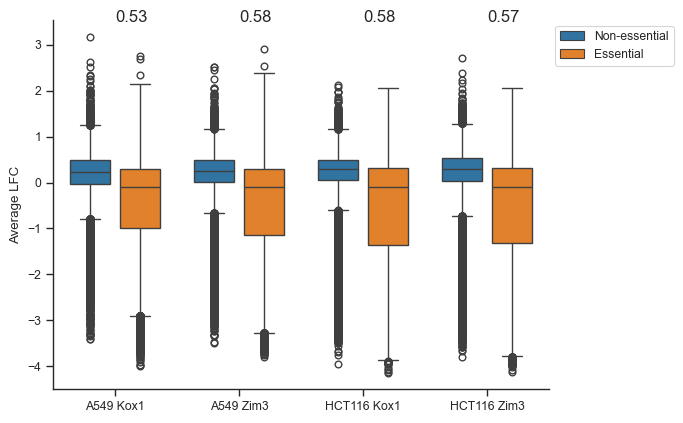

In [8]:
sns.boxplot(data = plot_df, x = 'condition', y = 'Average LFC', hue = 'Category', palette = {'Non-essential':'#1f77b4','Essential':'#ff7f0e'},
            order = ["A549 Kox1","A549 Zim3","HCT116 Kox1","HCT116 Zim3"],gap = 0.2)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('')

sns.despine()
for condition in ssmd_df['condition']:
    ssmd = round(float(ssmd_df.loc[ssmd_df['condition'] == condition,'ssmd']),2)
    plt.text(x=condition,y=3.5,s=ssmd,fontsize=12)

gpp.savefig(figure1_outpath+'guide_lfc_boxplot_ssmd.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'A549')

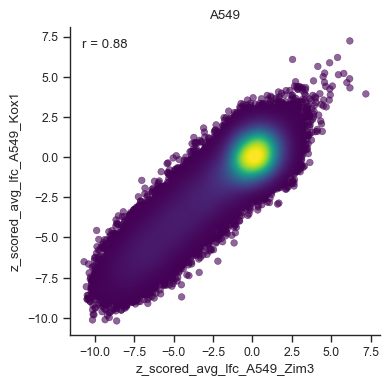

In [9]:
# compare domains in A549s
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_A549_Zim3', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('A549')

Text(0.5, 1.0, 'HCT116')

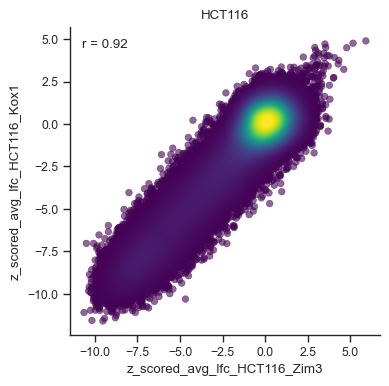

In [10]:
# compare domains in HCT116s
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_HCT116_Kox1')
sns.despine()
plt.title('HCT116')

Text(0.5, 1.0, 'Kox1')

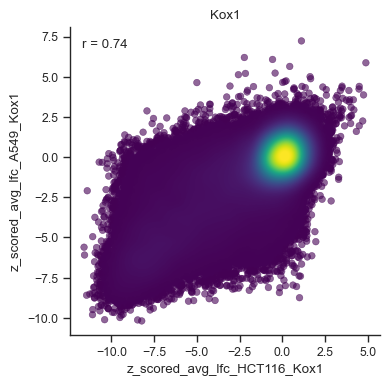

In [11]:
# compare Kox1 performance across cell lines
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Kox1', y='z_scored_avg_lfc_A549_Kox1')
sns.despine()
plt.title('Kox1')

Text(0.5, 1.0, 'Zim3')

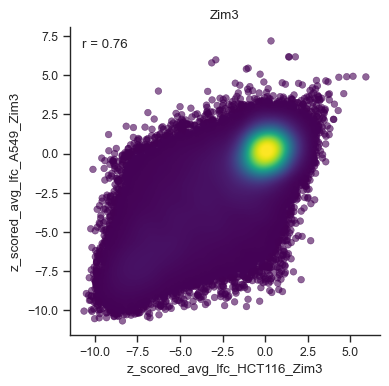

In [12]:
# compare Zim3 performance across cell lines
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
gpp.add_correlation(data=merged_df, x='z_scored_avg_lfc_HCT116_Zim3', y='z_scored_avg_lfc_A549_Zim3')
sns.despine()
plt.title('Zim3')